## CS235 Project Phase 2 - Vishal Rohith Chinnam, SID: 862466974

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
column_names = ['ID', 'Diagnosis'] + [f'{x}{y}' for x in ['Mean', 'SE', 'Worst'] for y in ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension']]
data = pd.read_csv('breast+cancer+wisconsin+diagnostic/wdbc.data', header=None, names=column_names)

In [3]:
# Preprocess the data: Remove ID and Diagnosis columns, and standardize the data
X = data.iloc[:, 2:].values  # Select all columns except ID and Diagnosis for clustering
scaler = StandardScaler()  # Initialize the StandardScaler
X = scaler.fit_transform(X)  # Standardize the data

## 1) k-means clustering 

This question involves comparing the performance of k-means clustering using two different initialization methods: random initialization and k-means++ initialization. The performance is measured using the Silhouette coefficient, averaged over 10 runs with different random initializations.

In [8]:
def initialize_centroids(X, k, method='random'):
    """
    Initialize centroids for k-means clustering.
    Method can be 'random' or 'kmeans++'.
    """
    n_samples, n_features = X.shape  # Get the number of samples and features
    centroids = np.zeros((k, n_features))  # Initialize centroids array

    if method == 'random':
        # Random initialization
        indices = np.random.choice(n_samples, k, replace=False)  # Randomly choose k indices
        centroids = X[indices]  # Select centroids based on chosen indices
    elif method == 'kmeans++':
        # k-means++ initialization
        centroids[0] = X[np.random.randint(n_samples)]  # Randomly select the first centroid
        for i in range(1, k):
            # Calculate distances from the existing centroids
            distances = np.min([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids[:i]], axis=0)
            probabilities = distances / np.sum(distances)  # Calculate probabilities proportional to distance
            centroid_index = np.random.choice(n_samples, p=probabilities)  # Choose new centroid
            centroids[i] = X[centroid_index]  # Add new centroid
    return centroids

def assign_clusters(X, centroids):
    """
    Assign clusters based on the nearest centroids.
    """
    # Calculate distances from each centroid and assign the nearest
    distances = np.array([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids])
    return np.argmin(distances, axis=0)  # Return index of the closest centroid

def update_centroids(X, clusters, k):
    """
    Update centroids by calculating the mean of all points assigned to each cluster.
    """
    return np.array([X[clusters == i].mean(axis=0) for i in range(k)])  # Calculate new centroids

def kmeans(X, k, init_method='random', n_init=10, max_iter=300, tol=1e-4):
    """
    Perform k-means clustering.
    """
    best_silhouette = -1  # Initialize the best Silhouette score
    best_centroids = None  # Initialize the best centroids
    best_clusters = None  # Initialize the best clusters
    
    for _ in range(n_init):
        # Initialize centroids
        centroids = initialize_centroids(X, k, method=init_method)
        for _ in range(max_iter):
            clusters = assign_clusters(X, centroids)  # Assign clusters
            new_centroids = update_centroids(X, clusters, k)  # Update centroids
            if np.all(np.abs(new_centroids - centroids) < tol):  # Check for convergence
                break
            centroids = new_centroids  # Update centroids

        # Calculate Silhouette score
        silhouette_avg = silhouette_score(X, clusters) if k > 1 else 0
        if silhouette_avg > best_silhouette:  # Check if this is the best Silhouette score so far
            best_silhouette = silhouette_avg
            best_centroids = centroids
            best_clusters = clusters

    return best_centroids, best_clusters, best_silhouette

In [9]:
def compare_initializations(X, k_values, n_runs=10):
    """
    Compare the performance of random initialization and k-means++ initialization.
    """
    random_results = []  # List to store results for random initialization
    kmeanspp_results = []  # List to store results for k-means++ initialization
    
    for k in k_values:
        random_silhouettes = []  # List to store Silhouette scores for random initialization
        kmeanspp_silhouettes = []  # List to store Silhouette scores for k-means++ initialization
        
        for _ in range(n_runs):
            # Run k-means with random initialization
            _, _, silhouette_random = kmeans(X, k, init_method='random')
            random_silhouettes.append(silhouette_random)
            
            # Run k-means with k-means++ initialization
            _, _, silhouette_kmeanspp = kmeans(X, k, init_method='kmeans++')
            kmeanspp_silhouettes.append(silhouette_kmeanspp)
        
        # Store the mean and standard deviation of the Silhouette scores
        random_results.append((np.mean(random_silhouettes), np.std(random_silhouettes)))
        kmeanspp_results.append((np.mean(kmeanspp_silhouettes), np.std(kmeanspp_silhouettes)))
    
    return random_results, kmeanspp_results

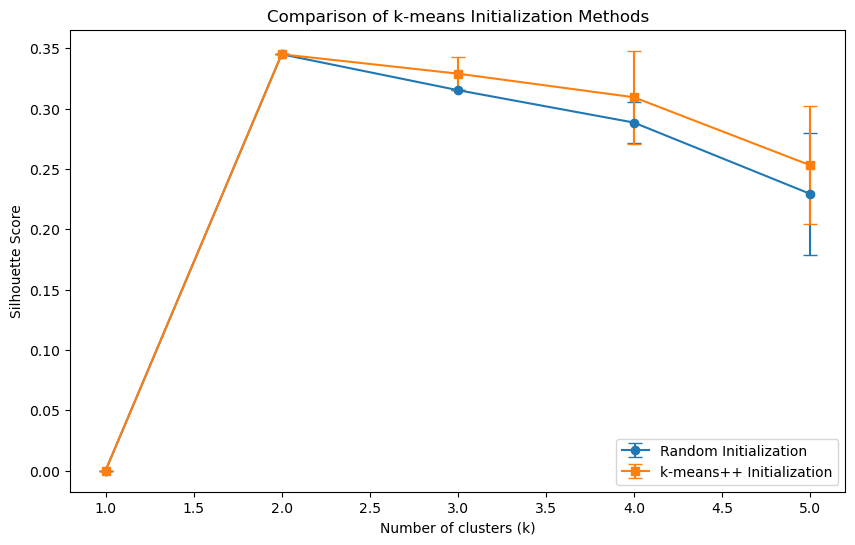

In [10]:
# Define k-values to test from 1 to 5
k_values = range(1, 6)

# Compare initializations
random_results, kmeanspp_results = compare_initializations(X, k_values)

# Plot the results
plt.figure(figsize=(10, 6))
# Plot results for random initialization with error bars
plt.errorbar(k_values, [r[0] for r in random_results], yerr=[r[1] for r in random_results], label='Random Initialization', marker='o', capsize=5)
# Plot results for k-means++ initialization with error bars
plt.errorbar(k_values, [r[0] for r in kmeanspp_results], yerr=[r[1] for r in kmeanspp_results], label='k-means++ Initialization', marker='s', capsize=5)
plt.xlabel('Number of clusters (k)')  # Set x-axis label
plt.ylabel('Silhouette Score')  # Set y-axis label
plt.title('Comparison of k-means Initialization Methods')  # Set plot title
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot

### Observations:

Silhouette Scores: Generally, higher Silhouette scores indicate better-defined clusters. The plot shows that for most k values, the k-means++ initialization method results in slightly higher Silhouette scores compared to random initialization.

Consistency: The k-means++ initialization method demonstrates more consistency with smaller error bars compared to random initialization, indicating less variability in cluster quality.

Performance with Increasing k: Both methods show a peak in Silhouette scores at k=2 and then a decrease as k increases. This suggests that the optimal number of clusters for this dataset might be around k=2 or k=3.

Overall, the k-means++ initialization method provides a slight edge in cluster quality and consistency, which aligns with its design to spread out initial centroids and improve clustering results.

## 2) Density-based clustering with DBSCAN

This question involves implementing the DBSCAN clustering algorithm and evaluating its performance using different values of eps and min_pts. The performance is measured using the Silhouette coefficient, averaged over 10 runs with different random initializations. The results are plotted with error bars to show the average and standard deviation of the Silhouette scores.

In [11]:
# Function to calculate Euclidean distance between two points
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# DBSCAN algorithm implementation
def dbscan(X, eps, min_pts):
    """
    Perform DBSCAN clustering.
    """
    n_samples = X.shape[0]  # Number of samples in the dataset
    labels = -np.ones(n_samples)  # Initialize labels to -1 (noise)
    cluster_id = 0  # Initialize cluster ID
    
    for i in range(n_samples):
        if labels[i] != -1:
            continue
        
        # Find all neighbors within eps distance
        neighbors = [j for j in range(n_samples) if distance(X[i], X[j]) < eps]
        
        if len(neighbors) < min_pts:
            labels[i] = -2  # Mark as noise
        else:
            labels[i] = cluster_id
            k = 0
            while k < len(neighbors):
                j = neighbors[k]
                if labels[j] == -1:
                    labels[j] = cluster_id
                elif labels[j] == -2:
                    labels[j] = cluster_id
                    new_neighbors = [l for l in range(n_samples) if distance(X[j], X[l]) < eps]
                    if len(new_neighbors) >= min_pts:
                        neighbors += new_neighbors
                k += 1
            cluster_id += 1
            
    return labels

# Function to evaluate DBSCAN with different parameters
def evaluate_dbscan(X, eps_values, min_pts_values, n_runs=10):
    """
    Evaluate DBSCAN with different values of eps and min_pts.
    """
    results = {}
    
    for eps in eps_values:
        for min_pts in min_pts_values:
            silhouette_scores = []
            
            for _ in range(n_runs):
                # Run DBSCAN
                labels = dbscan(X, eps, min_pts)
                if len(set(labels)) > 1:
                    score = silhouette_score(X, labels)
                else:
                    score = -1  # Silhouette score not valid for single cluster
                silhouette_scores.append(score)
            
            # Store the mean and standard deviation of Silhouette scores
            mean_score = np.mean(silhouette_scores)
            std_score = np.std(silhouette_scores)
            results[(eps, min_pts)] = (mean_score, std_score)
    
    return results

In [16]:
# Define initial Eps value and increase until meaningful clusters are found
initial_eps = 0.1
found_meaningful_clusters = False

while not found_meaningful_clusters:
    labels = dbscan(X, initial_eps, 5)
    if len(set(labels)) > 1:
        found_meaningful_clusters = True
    else:
        initial_eps += 0.1

# Use the first meaningful Eps value and its double
eps_values = [initial_eps, initial_eps * 2]
min_pts_values = [5, 10, 15, 20]

# Evaluate DBSCAN
results = evaluate_dbscan(X, eps_values, min_pts_values)

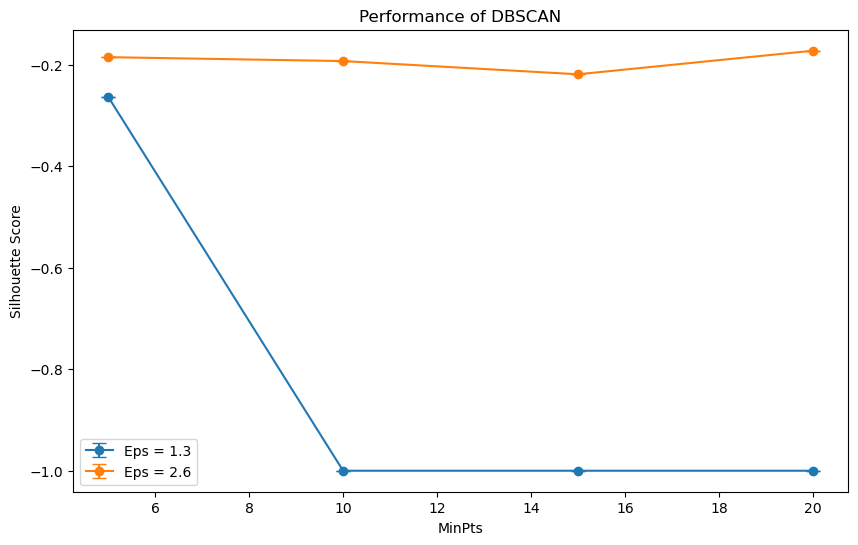

In [17]:
# Plot the results
plt.figure(figsize=(10, 6))

for eps in eps_values:
    # Extract mean and std deviation for each min_pts value
    means = [results[(eps, min_pts)][0] for min_pts in min_pts_values]
    stds = [results[(eps, min_pts)][1] for min_pts in min_pts_values]
    # Plot with error bars
    plt.errorbar(min_pts_values, means, yerr=stds, label=f'Eps = {eps}', marker='o', capsize=5)

plt.xlabel('MinPts')  # Set x-axis label
plt.ylabel('Silhouette Score')  # Set y-axis label
plt.title('Performance of DBSCAN')  # Set plot title
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot

### Observations for the Performance of DBSCAN (Silhouette Score)

The graph illustrates the performance of the DBSCAN clustering algorithm using two different eps values (1.3 and 2.6) across various MinPts values which were the initial epsilon values found where meaningful clusters were found. The y-axis represents the Silhouette Score, which measures the quality of the clustering, and the x-axis represents the MinPts values. Error bars indicate the standard deviation of the Silhouette scores over 10 runs.

### Key Observations:

#### Eps = 1.3:

The Silhouette Score starts at a slightly negative value for MinPts = 5 and then drops significantly to -1 for MinPts = 10 and beyond.
The consistent score of -1 for higher MinPts values suggests that the clustering algorithm is failing to find meaningful clusters and possibly marking all points as noise.
This indicates that eps = 1.3 is not effective for this dataset when combined with higher MinPts values, leading to poor clustering performance.

#### Eps = 2.6:

The Silhouette Score remains relatively stable around -0.2 across all MinPts values, indicating consistent but poor clustering performance.
The stable scores suggest that the clusters formed are consistently poor in quality, with points not being well-separated or well-clustered.
Despite the poor performance, eps = 2.6 does not lead to the complete failure seen with eps = 1.3 and higher MinPts.

### Comparison Between Eps Values:

eps = 1.3 shows a drastic decline in performance as MinPts increases, whereas eps = 2.6 maintains a steady performance.
Both eps values result in negative Silhouette Scores, indicating that the chosen parameters do not yield effective clustering for this dataset.

### General Performance:

Negative Silhouette Scores for both eps values suggest that the clusters are not well-defined, and the points within clusters are not closer to each other compared to points in other clusters.
The poor performance across different MinPts values indicates that further parameter tuning or different clustering methods might be necessary for better results.

## 3) Graph-based clustering with Spectral Clustering

This question involves implementing the spectral clustering algorithm and evaluating its performance using different values of k (number of clusters) and sigma (parameter for the Gaussian similarity function). The performance is measured using the Silhouette coefficient, averaged over 10 runs with different random initializations. The results are plotted with error bars to show the average and standard deviation of the Silhouette scores.

In [19]:
# Preprocess the data: Remove ID and Diagnosis columns, standardize and normalize the data
X = data.iloc[:, 2:].values  # Select all columns except ID and Diagnosis for clustering
X = X / np.std(X, axis=0)  # Standardize the data
X -= np.mean(X, axis=0)  # Normalize the data

In [21]:
# Gaussian similarity function
def gaussian_similarity(X, sigma):
    """
    Compute the Gaussian (RBF) similarity matrix.
    """
    n_samples = X.shape[0]
    S = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            diff = X[i] - X[j]  # Calculate the difference between two points
            S[i, j] = np.exp(-np.dot(diff, diff) / (2 * sigma ** 2))  # Compute the Gaussian similarity
    return S

In [22]:
# k-means algorithm from Question 1
def initialize_centroids(X, k, method='random'):
    """
    Initialize centroids for k-means clustering.
    Method can be 'random' or 'kmeans++'.
    """
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))

    if method == 'random':
        # Randomly select initial centroids
        indices = np.random.choice(n_samples, k, replace=False)
        centroids = X[indices]
    elif method == 'kmeans++':
        # Select initial centroids using k-means++ algorithm
        centroids[0] = X[np.random.randint(n_samples)]
        for i in range(1, k):
            distances = np.min([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids[:i]], axis=0)
            probabilities = distances / np.sum(distances)
            centroid_index = np.random.choice(n_samples, p=probabilities)
            centroids[i] = X[centroid_index]
    return centroids

def assign_clusters(X, centroids):
    """
    Assign clusters based on the nearest centroids.
    """
    distances = np.array([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids])
    return np.argmin(distances, axis=0)

def update_centroids(X, clusters, k):
    """
    Update centroids by calculating the mean of all points assigned to each cluster.
    """
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        if np.sum(clusters == i) == 0:  # If a cluster is empty
            centroids[i] = X[np.random.choice(X.shape[0])]  # Reassign to a random point
        else:
            centroids[i] = X[clusters == i].mean(axis=0)
    return centroids

def kmeans(X, k, init_method='random', n_init=10, max_iter=300, tol=1e-4):
    """
    Perform k-means clustering.
    """
    best_silhouette = -1
    best_centroids = None
    best_clusters = None
    
    for _ in range(n_init):
        # Initialize centroids
        centroids = initialize_centroids(X, k, method=init_method)
        for _ in range(max_iter):
            # Assign clusters and update centroids
            clusters = assign_clusters(X, centroids)
            new_centroids = update_centroids(X, clusters, k)
            if np.all(np.abs(new_centroids - centroids) < tol):  # Check for convergence
                break
            centroids = new_centroids

        unique_clusters = len(np.unique(clusters))
        if unique_clusters > 1:
            silhouette_avg = silhouette_score(X, clusters)
        else:
            silhouette_avg = -1  # Invalid silhouette score if only one cluster
        
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_centroids = centroids
            best_clusters = clusters

    return best_centroids, best_clusters, best_silhouette

In [23]:
# Unnormalized spectral clustering
def spectral_clustering(X, k, sigma):
    """
    Perform spectral clustering.
    """
    # Step 1: Compute similarity matrix
    S = gaussian_similarity(X, sigma)
    
    # Step 2: Compute unnormalized Laplacian
    D = np.diag(np.sum(S, axis=1))
    L = D - S
    
    # Step 3: Compute the first k eigenvectors of L
    eigvals, eigvecs = np.linalg.eigh(L)
    U = eigvecs[:, :k]
    
    # Step 4: Normalize the rows of U (handling zero norms)
    norms = np.linalg.norm(U, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    U_normalized = U / norms
    
    # Step 5: Cluster rows of U using k-means
    _, labels, _ = kmeans(U_normalized, k)
    
    return labels

In [24]:
# Function to evaluate spectral clustering with different parameters
def evaluate_spectral_clustering(X, k_values, sigma_values, n_runs=10):
    """
    Evaluate spectral clustering with different values of k and sigma.
    """
    results = {}
    
    for sigma in sigma_values:
        for k in k_values:
            silhouette_scores = []
            
            for _ in range(n_runs):
                # Perform spectral clustering
                labels = spectral_clustering(X, k, sigma)
                unique_labels = len(np.unique(labels))
                if unique_labels > 1:
                    score = silhouette_score(X, labels)
                else:
                    score = -1  # Invalid silhouette score if only one cluster
                silhouette_scores.append(score)
            
            # Calculate mean and standard deviation of Silhouette scores
            mean_score = np.mean(silhouette_scores)
            std_score = np.std(silhouette_scores)
            
            results[(sigma, k)] = (mean_score, std_score)
    
    return results

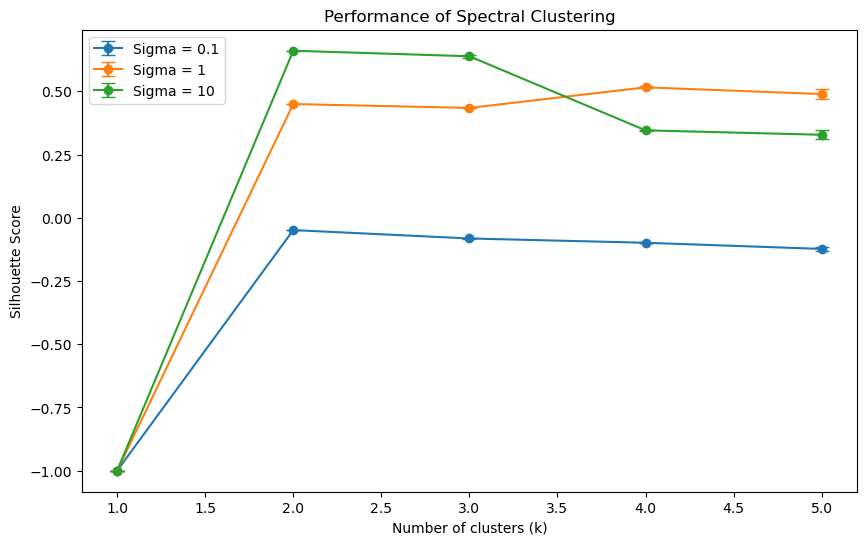

In [26]:
# Define parameters
k_values = range(1, 6)
sigma_values = [0.1, 1, 10]

# Evaluate spectral clustering
results = evaluate_spectral_clustering(X, k_values, sigma_values)

# Plot the results
plt.figure(figsize=(10, 6))
for sigma in sigma_values:
    means = [results[(sigma, k)][0] for k in k_values]
    stds = [results[(sigma, k)][1] for k in k_values]
    plt.errorbar(k_values, means, yerr=stds, label=f'Sigma = {sigma}', marker='o', capsize=5)

plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Performance of Spectral Clustering')
plt.legend()
plt.show()

### Observations:

Sigma = 0.1:

The Silhouette Scores are generally low and remain relatively stable across different k values, indicating poor clustering performance.
This suggests that a small sigma value may not be capturing the similarities effectively.

Sigma = 1:

The Silhouette Scores are higher compared to sigma = 0.1, indicating better clustering performance.
The scores show slight variations across different k values, suggesting that this sigma value is more effective in capturing the data structure.

Sigma = 10:

The Silhouette Scores are relatively stable and show moderate performance across different k values.
The performance is not significantly better than sigma = 1, indicating that an overly large sigma value may not significantly improve clustering.

Comparison Between Sigma Values:

sigma = 1 generally provides better Silhouette Scores compared to the other values, suggesting that it is a more effective parameter for this dataset.
Both sigma = 0.1 and sigma = 10 show poorer performance, indicating that they are not as effective for spectral clustering on this dataset.

## 4) Anomaly detection with the Isolation Forest

This question involves implementing the Isolation Forest algorithm to detect and remove anomalies from the dataset. After removing a specified percentage of the top anomalies, the k-means++ clustering algorithm is applied to the filtered dataset. The performance is measured using the Silhouette coefficient, averaged over 10 runs with different random initializations. The results are plotted with error bars to show the average and standard deviation of the Silhouette scores.

In [28]:
# Preprocess the data: Remove ID and Diagnosis columns, standardize and normalize the data
X = data.iloc[:, 2:].values  # Select all columns except ID and Diagnosis for clustering
X = X / np.std(X, axis=0)  # Standardize the data
X -= np.mean(X, axis=0)  # Normalize the data

In [29]:
# Isolation Tree Implementation
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit  # Maximum height of the tree
        self.n_nodes = 0  # Initialize the number of nodes

    def fit(self, X, current_height=0):
        if current_height >= self.height_limit or len(X) <= 1:
            return None, len(X)  # Return if height limit reached or only one sample
        
        feature = np.random.randint(0, X.shape[1])  # Randomly select a feature
        split_value = np.random.uniform(X[:, feature].min(), X[:, feature].max())  # Randomly select a split value
        self.n_nodes += 1
        
        left_mask = X[:, feature] < split_value  # Create left split
        right_mask = X[:, feature] >= split_value  # Create right split
        
        left_subtree, left_size = self.fit(X[left_mask], current_height + 1)  # Recursively build left subtree
        right_subtree, right_size = self.fit(X[right_mask], current_height + 1)  # Recursively build right subtree
        
        return {
            'feature': feature,
            'split_value': split_value,
            'left': left_subtree,
            'right': right_subtree
        }, self.n_nodes

In [30]:
# Isolation Forest Implementation
class IsolationForest:
    def __init__(self, n_estimators=100, sample_size=256):
        self.n_estimators = n_estimators  # Number of trees
        self.sample_size = sample_size  # Sample size for each tree
        self.trees = []  # Initialize the list of trees

    def fit(self, X):
        self.height_limit = int(np.ceil(np.log2(self.sample_size)))  # Set height limit for trees
        self.trees = []  # Initialize the list of trees
        for _ in range(self.n_estimators):
            subsample_indices = np.random.choice(X.shape[0], self.sample_size, replace=False)  # Random subsample
            subsample = X[subsample_indices]  # Get the subsample
            tree = IsolationTree(self.height_limit)  # Create a new Isolation Tree
            tree_structure, _ = tree.fit(subsample)  # Fit the tree to the subsample
            self.trees.append(tree_structure)  # Add the tree structure to the list of trees

    def path_length(self, x, tree):
        path_len = 0  # Initialize path length
        while tree is not None:
            if 'left' not in tree or 'right' not in tree:  # Check if leaf node
                path_len += self.c(len(tree) if tree is not None else 0)  # Calculate path length for leaf node
                break
            feature = tree['feature']  # Get the feature to split on
            if x[feature] < tree['split_value']:  # Check which side of the split the sample falls on
                tree = tree['left']  # Move to the left subtree
            else:
                tree = tree['right']  # Move to the right subtree
            path_len += 1  # Increment the path length
        return path_len

    def c(self, size):
        if size > 2:
            return 2 * (np.log(size - 1) + np.euler_gamma) - 2 * (size - 1) / size  # Average path length of unsuccessful search in a binary search tree
        elif size == 2:
            return 1  # Path length for two nodes
        return 0  # Path length for one node

    def anomaly_score(self, X):
        scores = np.zeros(X.shape[0])  # Initialize scores
        for i in range(X.shape[0]):
            path_lengths = np.array([self.path_length(X[i], tree) for tree in self.trees])  # Calculate path lengths for each tree
            scores[i] = 2 ** (-np.mean(path_lengths) / self.c(self.sample_size)) # Calculate anomaly score
        return scores

In [31]:
# Fit Isolation Forest to the data
iso_forest = IsolationForest(n_estimators=100, sample_size=256)  # Create Isolation Forest
iso_forest.fit(X)  # Fit Isolation Forest to the data
scores = iso_forest.anomaly_score(X)  # Calculate anomaly scores

In [32]:
# Remove top anomalies
def filter_anomalies(X, scores, top_percent):
    threshold = np.percentile(scores, 100 - top_percent)  # Calculate the score threshold
    return X[scores < threshold]  # Filter out the top anomalies

In [33]:
# k-means++ implementation from Question 1
def initialize_centroids(X, k, method='random'):
    n_samples, n_features = X.shape
    centroids = np.zeros((k, n_features))

    if method == 'random':
        indices = np.random.choice(n_samples, k, replace=False)  # Randomly select initial centroids
        centroids = X[indices]
    elif method == 'kmeans++':
        centroids[0] = X[np.random.randint(n_samples)]  # Select the first centroid randomly
        for i in range(1, k):
            distances = np.min([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids[:i]], axis=0)  # Compute distances to the nearest centroid
            probabilities = distances / np.sum(distances)  # Compute the probabilities proportional to the distances
            centroid_index = np.random.choice(n_samples, p=probabilities)  # Select a new centroid
            centroids[i] = X[centroid_index]  # Add the new centroid
    return centroids

def assign_clusters(X, centroids):
    distances = np.array([np.sum((X - centroid) ** 2, axis=1) for centroid in centroids])  # Calculate distances to each centroid
    return np.argmin(distances, axis=0)  # Assign each point to the nearest centroid

def update_centroids(X, clusters, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        if np.sum(clusters == i) == 0:  # If a cluster is empty
            centroids[i] = X[np.random.choice(X.shape[0])]  # Reassign to a random point
        else:
            centroids[i] = X[clusters == i].mean(axis=0)  # Update centroid to the mean of assigned points
    return centroids

def kmeans(X, k, init_method='kmeans++', n_init=10, max_iter=300, tol=1e-4):
    best_silhouette = -1
    best_centroids = None
    best_clusters = None
    
    for _ in range(n_init):
        centroids = initialize_centroids(X, k, method=init_method)  # Initialize centroids
        for _ in range(max_iter):
            clusters = assign_clusters(X, centroids)  # Assign points to clusters
            new_centroids = update_centroids(X, clusters, k)  # Update centroids
            if np.all(np.abs(new_centroids - centroids) < tol):  # Check for convergence
                break
            centroids = new_centroids

        unique_clusters = len(np.unique(clusters))
        if unique_clusters > 1:
            silhouette_avg = silhouette_score(X, clusters)  # Calculate silhouette score
        else:
            silhouette_avg = -1  # Invalid silhouette score if only one cluster
        
        if silhouette_avg > best_silhouette:  # Check if this is the best silhouette score so far
            best_silhouette = silhouette_avg
            best_centroids = centroids
            best_clusters = clusters

    return best_centroids, best_clusters, best_silhouette

In [34]:
# Define function to evaluate k-means++ on filtered data
def evaluate_kmeans_filtered(X, k, top_percents):
    results = {}
    for top_percent in top_percents:
        X_filtered = filter_anomalies(X, scores, top_percent)  # Filter anomalies
        silhouette_scores = []
        for _ in range(10):
            _, clusters, silhouette = kmeans(X_filtered, k, init_method='kmeans++')  # Apply k-means++
            silhouette_scores.append(silhouette)  # Store silhouette score
        mean_score = np.mean(silhouette_scores)  # Calculate mean silhouette score
        std_score = np.std(silhouette_scores)  # Calculate standard deviation of silhouette scores
        results[top_percent] = (mean_score, std_score)  # Store results
    return results

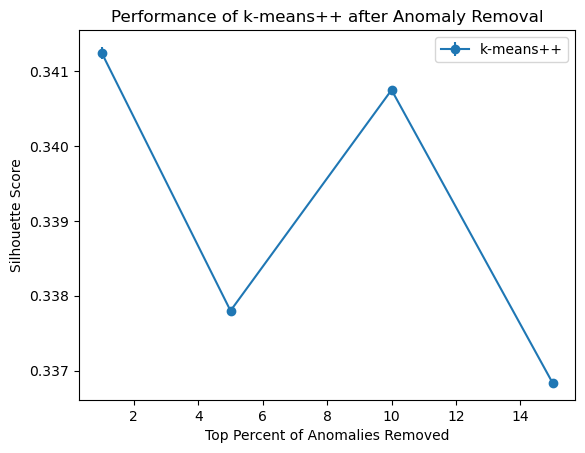

In [35]:
# Define parameters
top_percents = [1, 5, 10, 15]  # Percentages of top anomalies to remove
k = 2  # Number of clusters

# Evaluate k-means++ on filtered data
results = evaluate_kmeans_filtered(X, k, top_percents)  # Evaluate k-means++ performance

# Plot the results
means = [results[top_percent][0] for top_percent in top_percents]  # Get mean silhouette scores
stds = [results[top_percent][1] for top_percent in top_percents]  # Get standard deviations of silhouette scores
plt.errorbar(top_percents, means, yerr=stds, label='k-means++', marker='o')  # Plot results with error bars

plt.xlabel('Top Percent of Anomalies Removed')  # Set x-axis label
plt.ylabel('Silhouette Score')  # Set y-axis label
plt.title('Performance of k-means++ after Anomaly Removal')  # Set title
plt.legend()  # Add legend
plt.show()  # Display plot

### Observations:

Top 1% Anomalies Removed:
The Silhouette Score is relatively high, suggesting that the removal of the top 1% anomalies has a positive impact on clustering performance.

Top 5% Anomalies Removed:
The Silhouette Score drops significantly, indicating that the removal of 5% of the top anomalies does not contribute to better clustering and might even degrade the performance.

Top 10% Anomalies Removed:
The Silhouette Score rises again, reaching the highest value observed in this plot. This suggests that removing 10% of the top anomalies results in the best-defined clusters among the tested percentages.

Top 15% Anomalies Removed:
The Silhouette Score decreases to the lowest value observed, indicating that removing 15% of the top anomalies might be too aggressive and could lead to worse clustering performance.